In [1]:
import pandas as pd
import sqlalchemy
import pyodbc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pw import *

In [2]:
from sqlalchemy.engine import URL
connection_string = "DRIVER={ODBC Driver 17 for SQL Server};SERVER="+pna_server+";DATABASE="+pna_db+";UID="+user+";PWD="+pwd+";Trusted_Connection=YES"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

from sqlalchemy import create_engine
engine = create_engine(connection_url)

from sqlalchemy.types import NVARCHAR
cursor = engine.connect()

# Initial Config

**Set brand parameter: CT or KP.**

This will then run 3 scripts:

* Annualized Catalog Costs
* Non-Holdout Counts, Revenue, and Profit.
* Holdout Counts, Revenue, and PRofit.

In [3]:
brand = "CT"

In [4]:
costs_query = (
"""
SELECT 
	A.date,
	A.cost,
	B.sends,
    CAST(A.cost / B.sends as DECIMAL(8,2)) as cost_per_catalog,
	A.brand
FROM (
	SELECT 
		year(postdate) as date,
		SUM(netamount) as cost,
		brand
	FROM """+brand+""".reporting.Accounting A
	WHERE accounttype = 'Expense'
	AND accountname IN (
		'Catalog Expenses : Catalog Expenses',
		'Catalog Expenses : Catalog Paper',
		'Catalog Expenses : Catalog Postage',
		'Catalog Expenses : Catalog Printing' )
    AND postdate > '9/1/2019' -- Catalog data goes to OC19
	GROUP BY
		year(postdate),
		brand
) A
LEFT JOIN (
	SELECT 
		year(inhome) as date,
		count(sourcecode) as sends
	FROM """+brand+""".reporting.Catalog
	WHERE holdout = 0
	GROUP BY
		year(inhome)
) B ON A.date = B.date 
ORDER BY 
	A.date DESC
"""
)

costs_df = pd.read_sql_query(costs_query, engine)

costs_df

,date,cost,sends,cost_per_catalog,brand
0,2024,39861.46,103318,0.39,Connecting Threads (CT)
1,2023,933838.75,1142930,0.82,Connecting Threads (CT)
2,2022,1126396.88,1499664,0.75,Connecting Threads (CT)
3,2021,903967.91,1347300,0.67,Connecting Threads (CT)
4,2020,838611.03,1512140,0.55,Connecting Threads (CT)


* **The 5 yr average cost for CT:** 0.695
* **The 5 yr average cost for KP:** 0.675
* For the purpose of seeing if mailing is viable, we are setting the cost to: 82 cents.

In [5]:
catalogs_query = (
"""
SELECT 
	DATEFROMPARTS(YEAR(inhome), MONTH(inhome), 1) as date,
	catalogcode,
    segment,
	COUNT(sourcecode) as sends,
	SUM(revenue) as revenue,
	SUM(profit) as profit,
    SUM(profit) / COUNT(sourcecode) as ppc
FROM """+brand+""".reporting.Catalog
WHERE holdout = 0
GROUP BY
	DATEFROMPARTS(YEAR(inhome), MONTH(inhome), 1),
	catalogcode,
    segment
ORDER BY DATEFROMPARTS(YEAR(inhome), MONTH(inhome), 1) DESC
"""
)

catalogs_df = pd.read_sql_query(catalogs_query, engine)

# Extract the two-letter prefix
catalogs_df['mailing'] = catalogs_df['catalogcode'].str[:2]

In [6]:
holdouts_query = (
"""
SELECT 
	DATEFROMPARTS(YEAR(inhome), MONTH(inhome), 1) as date,
	catalogcode,
    segment,
	COUNT(sourcecode) as sends,
	SUM(revenue) as revenue,
	SUM(profit) as profit,
    SUM(profit) / COUNT(sourcecode) as ppc
FROM """+brand+""".reporting.Catalog
WHERE holdout = 1
GROUP BY
	DATEFROMPARTS(YEAR(inhome), MONTH(inhome), 1),
	catalogcode,
    segment
ORDER BY DATEFROMPARTS(YEAR(inhome), MONTH(inhome), 1) DESC
"""
)

holdouts_df = pd.read_sql_query(holdouts_query, engine)

# Extract the two-letter prefix
holdouts_df['mailing'] = holdouts_df['catalogcode'].str[:2]

# Average Profit Per Catalog By Mailing

What we're doing:
* Creating a new dataframe summing profit / total sends for mailed and holdout groups.
* Creating a custom order of catalog mailings.
* Graphing the profit per catalog side-by-side.

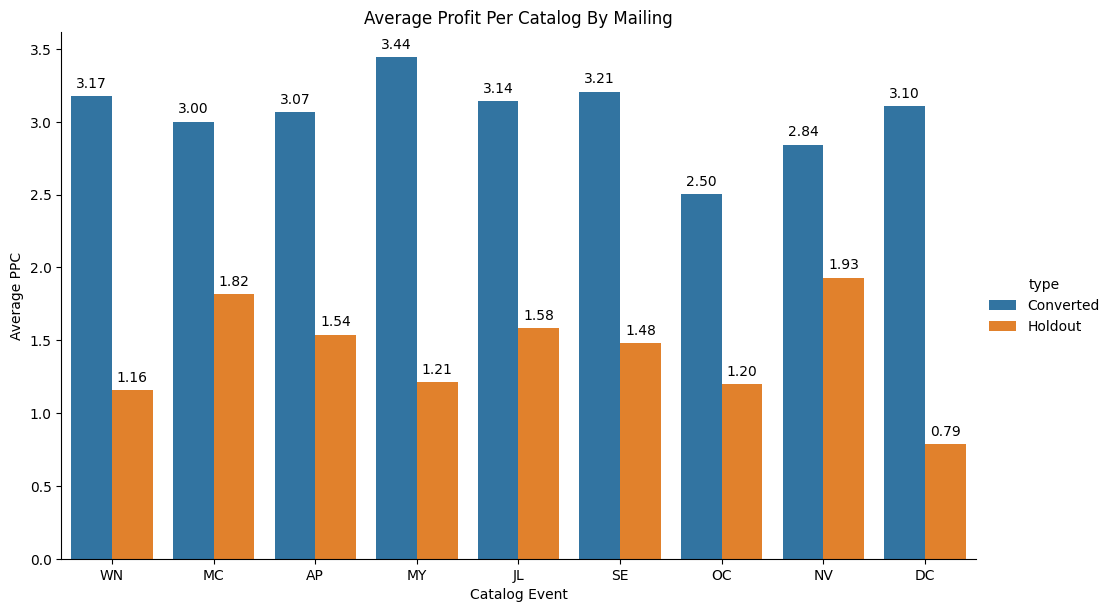

In [7]:
# Calculate profit per catalog, across all catalogs.
converted_df = catalogs_df.groupby('mailing', observed=True)[['profit', 'sends']].sum().reset_index()
converted_df['ppc'] = converted_df['profit'] / converted_df['sends']
# Calculate profit per catalom from holdout groups, across all catalogs.
holdout_df = holdouts_df.groupby('mailing', observed=True)[['profit', 'sends']].sum().reset_index()
holdout_df['ppc'] = holdout_df['profit'] / holdout_df['sends']

# Combine the dataframes with an additional 'type' column to distinguish them
converted_df['type'] = 'Converted'
holdout_df['type'] = 'Holdout'
combined_df = pd.concat([converted_df, holdout_df])

# Define the desired order for the x-axis
order = ['WN', 'MC', 'AP', 'MY', 'JL', 'SE', 'OC', 'NV', 'DC']

# Using seaborn's catplot to plot the data side by side
g = sns.catplot(x='mailing', y='ppc', hue='type', data=combined_df, kind='bar', order=order, height=6, aspect=10/6)

# Adding data labels only for non-zero bars
for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:  # Check if the bar height is greater than 0
            ax.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

# Adding the title and labels
plt.title('Average Profit Per Catalog By Mailing')
plt.xlabel('Catalog Event')
plt.ylabel('Average PPC')

plt.show()

# Average Profit Per Catalog By Segment
What we're doing:
* Creating a new dataframe summing profit / total sends for mailed and holdout groups by segment.
    * Removing non-standard mailing segments that will skew results over time.
* Graphing the profit per catalog side-by-side.

Goal:
* Find low performing segments, to find time-period required to meet cost.
* From there, we decide how many times a year it would be beneficial to mail the segments so we capture revenue without over mailing.

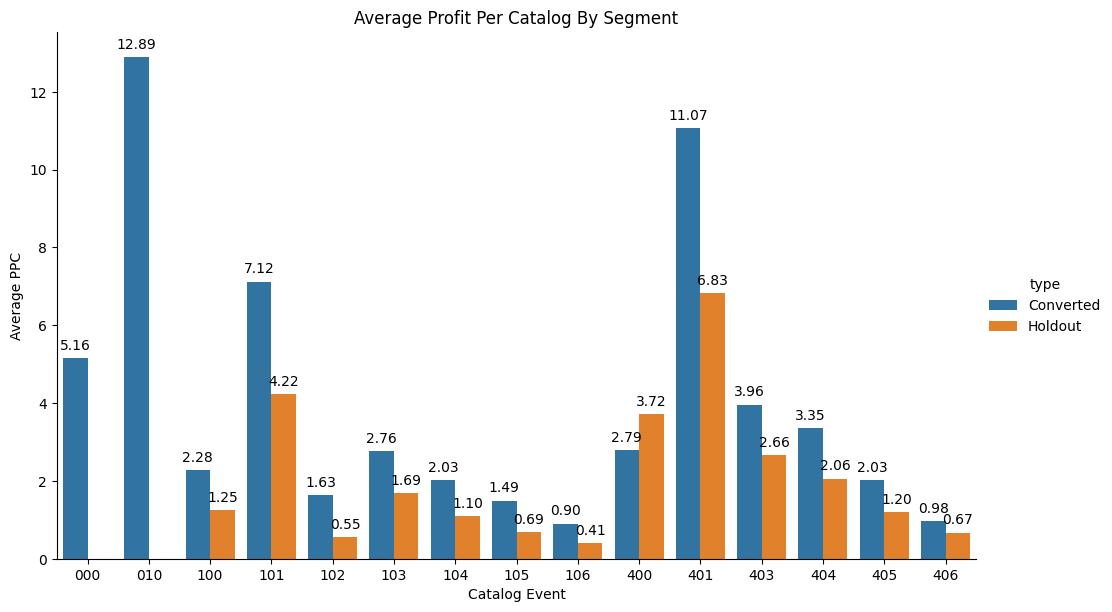

In [8]:
# Calculate profit per catalog, across all catalogs.
converted_segments_df = catalogs_df.groupby('segment', observed=True)[['profit', 'sends']].sum().reset_index()
converted_segments_df['ppc'] = converted_segments_df['profit'] / converted_segments_df['sends']
converted_segments_df = converted_segments_df[~converted_segments_df['segment'].str.match(r'^[289]|[A-Za-z]') & ~converted_segments_df['segment'].isin(['107', '108'])]
# Calculate profit per catalom from holdout groups, across all catalogs.
holdout_segments_df = holdouts_df.groupby('segment', observed=True)[['profit', 'sends']].sum().reset_index()
holdout_segments_df['ppc'] = holdout_segments_df['profit'] / holdout_segments_df['sends']
holdout_segments_df = holdout_segments_df[~holdout_segments_df['segment'].str.match(r'^[289]|[A-Za-z]') & ~holdout_segments_df['segment'].isin(['107', '108'])]

# Combine the dataframes with an additional 'type' column to distinguish them
converted_segments_df['type'] = 'Converted'
holdout_segments_df['type'] = 'Holdout'
combined_segments_df = pd.concat([converted_segments_df, holdout_segments_df])

# Using seaborn's catplot to plot the data side by side
g = sns.catplot(x='segment', y='ppc', hue='type', data=combined_segments_df, kind='bar', height=6, aspect=10/6)

# Adding data labels only for non-zero bars
for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:  # Check if the bar height is greater than 0
            ax.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

# Adding the title and labels
plt.title('Average Profit Per Catalog By Segment')
plt.xlabel('Catalog Event')
plt.ylabel('Average PPC')

# Print graph.
plt.show()

# In-Depth Segment Review
PPC Lift (Adjusted) = Mailed Segment PPC - (Holdout PPC + Avg Mailing Cost)

* 106 & 406 groups are doing awful in a 30 day window.
* 105 & 405 begin to struggle within a 30 day window.

In [9]:
# Set Cost To Current Mailing Costs.
cost = 0.82

# Merge data frames to find difference in PPC
ppc_df = converted_segments_df.merge(holdout_segments_df, on='segment', suffixes=('_conv', '_hold'))
ppc_df['ppc_lift'] = ppc_df['ppc_conv'] - ppc_df['ppc_hold']
# Subtract average catalog cost.
ppc_df['PPC Lift (Adjusted)'] = ppc_df['ppc_lift'] - cost
# Limit columns
ppc_df = ppc_df[['segment', 'PPC Lift (Adjusted)']]

# Print df with lift.
display(ppc_df)

,segment,PPC Lift (Adjusted)
0,000,4.341305
1,100,0.206111
2,101,2.079927
3,102,0.255583
4,103,0.250410
5,104,0.107100
6,105,-0.020772
7,106,-0.322523
8,400,-1.755117
9,401,3.416129


### Segment Profit Per Catalog
* Below are obnoxiously long queries, with increasing 10 day windows of PPC for each segment.
  * Easier than recursively calling to find days until PPC > 0.
* Create a heatmap to see when segments begin to become profitable over the holdout group.

In [10]:
segment_ppc = (
"""
WITH SENDS AS (
    SELECT 
        segment,
        COUNT(sourcecode) as sends
    FROM """+brand+""".reporting.Catalog
    WHERE holdout = 0
    GROUP BY segment
),
Profit_10_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 10, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_20_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 20, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_30_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 30, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_40_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 40, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_50_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 50, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_60_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 60, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_70_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 70, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_80_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 80, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_90_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 90, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_100_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 100, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_110_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 110, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_120_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 120, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_130_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 130, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_140_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 140, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
),
Profit_150_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 150, a.inhome)
    AND a.holdout = 0
    GROUP BY a.segment, c.sends
)
SELECT 
    A.segment,
    A.profit / NULLIF(A.sends, 0) as [10 Days],
    B.profit / NULLIF(B.sends, 0) as [20 Days],
    C.profit / NULLIF(C.sends, 0) as [30 Days],
    D.profit / NULLIF(D.sends, 0) as [40 Days],
    E.profit / NULLIF(E.sends, 0) as [50 Days],
    F.profit / NULLIF(F.sends, 0) as [60 Days],
    G.profit / NULLIF(G.sends, 0) as [70 Days],
    H.profit / NULLIF(H.sends, 0) as [80 Days],
    I.profit / NULLIF(I.sends, 0) as [90 Days],
    J.profit / NULLIF(J.sends, 0) as [100 Days],
    K.profit / NULLIF(K.sends, 0) as [110 Days],
    L.profit / NULLIF(L.sends, 0) as [120 Days],
    M.profit / NULLIF(M.sends, 0) as [130 Days],
    N.profit / NULLIF(N.sends, 0) as [140 Days],
    O.profit / NULLIF(O.sends, 0) as [150 Days]
FROM Profit_10_Days A
LEFT JOIN Profit_20_Days B ON A.segment = B.segment
LEFT JOIN Profit_30_Days C ON A.segment = C.segment
LEFT JOIN Profit_40_Days D ON A.segment = D.segment
LEFT JOIN Profit_50_Days E ON A.segment = E.segment
LEFT JOIN Profit_60_Days F ON A.segment = F.segment
LEFT JOIN Profit_70_Days G ON A.segment = G.segment
LEFT JOIN Profit_80_Days H ON A.segment = H.segment
LEFT JOIN Profit_90_Days I ON A.segment = I.segment
LEFT JOIN Profit_100_Days J ON A.segment = J.segment
LEFT JOIN Profit_110_Days K ON A.segment = K.segment
LEFT JOIN Profit_120_Days L ON A.segment = L.segment
LEFT JOIN Profit_130_Days M ON A.segment = M.segment
LEFT JOIN Profit_140_Days N ON A.segment = N.segment
LEFT JOIN Profit_150_Days O ON A.segment = O.segment
ORDER BY A.segment ASC
"""
)

segment_ppc_df = pd.read_sql_query(segment_ppc, engine)

# Drop non-standardized segments, errors, etc.
segment_ppc_df = segment_ppc_df[~segment_ppc_df['segment'].str.match(r'^[289]|[A-Za-z]') & ~segment_ppc_df['segment'].isin(['107', '108', '000', '010'])]
segment_ppc_df.reset_index(drop=True, inplace=True)

In [11]:
holdout_ppc = (
"""
WITH SENDS AS (
    SELECT 
        segment,
        COUNT(sourcecode) as sends
    FROM """+brand+""".reporting.Catalog
    WHERE holdout = 1
    GROUP BY segment
),
Profit_10_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 10, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_20_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 20, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_30_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 30, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_40_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 40, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_50_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 50, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_60_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 60, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_70_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 70, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_80_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 80, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_90_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 90, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_100_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 100, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_110_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 110, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_120_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 120, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_130_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 130, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_140_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 140, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
),
Profit_150_Days AS (
    SELECT 
        a.segment,
        SUM(b.grossprofit) as profit,
        c.sends 
    FROM """+brand+""".reporting.Catalog A
    INNER JOIN """+brand+""".reporting.Transactions B ON a.customerid = b.customerid
    LEFT JOIN SENDS C ON a.segment = c.segment
    WHERE b.orderdate BETWEEN a.inhome AND DATEADD(DAY, 150, a.inhome)
    AND a.holdout = 1
    GROUP BY a.segment, c.sends
)
SELECT 
    A.segment,
    A.profit / NULLIF(A.sends, 0) as [10 Days],
    B.profit / NULLIF(B.sends, 0) as [20 Days],
    C.profit / NULLIF(C.sends, 0) as [30 Days],
    D.profit / NULLIF(D.sends, 0) as [40 Days],
    E.profit / NULLIF(E.sends, 0) as [50 Days],
    F.profit / NULLIF(F.sends, 0) as [60 Days],
    G.profit / NULLIF(G.sends, 0) as [70 Days],
    H.profit / NULLIF(H.sends, 0) as [80 Days],
    I.profit / NULLIF(I.sends, 0) as [90 Days],
    J.profit / NULLIF(J.sends, 0) as [100 Days],
    K.profit / NULLIF(K.sends, 0) as [110 Days],
    L.profit / NULLIF(L.sends, 0) as [120 Days],
    M.profit / NULLIF(M.sends, 0) as [130 Days],
    N.profit / NULLIF(N.sends, 0) as [140 Days],
    O.profit / NULLIF(O.sends, 0) as [150 Days]
FROM Profit_10_Days A
LEFT JOIN Profit_20_Days B ON A.segment = B.segment
LEFT JOIN Profit_30_Days C ON A.segment = C.segment
LEFT JOIN Profit_40_Days D ON A.segment = D.segment
LEFT JOIN Profit_50_Days E ON A.segment = E.segment
LEFT JOIN Profit_60_Days F ON A.segment = F.segment
LEFT JOIN Profit_70_Days G ON A.segment = G.segment
LEFT JOIN Profit_80_Days H ON A.segment = H.segment
LEFT JOIN Profit_90_Days I ON A.segment = I.segment
LEFT JOIN Profit_100_Days J ON A.segment = J.segment
LEFT JOIN Profit_110_Days K ON A.segment = K.segment
LEFT JOIN Profit_120_Days L ON A.segment = L.segment
LEFT JOIN Profit_130_Days M ON A.segment = M.segment
LEFT JOIN Profit_140_Days N ON A.segment = N.segment
LEFT JOIN Profit_150_Days O ON A.segment = O.segment
ORDER BY A.segment ASC
"""
)

holdout_ppc_df = pd.read_sql_query(holdout_ppc, engine)

# Drop non-standardized segments, errors, etc.
holdout_ppc_df = holdout_ppc_df[~holdout_ppc_df['segment'].str.match(r'^[289]|[A-Za-z]') & ~holdout_ppc_df['segment'].isin(['107', '108', '000', '010'])]
holdout_ppc_df.reset_index(drop=True, inplace=True)

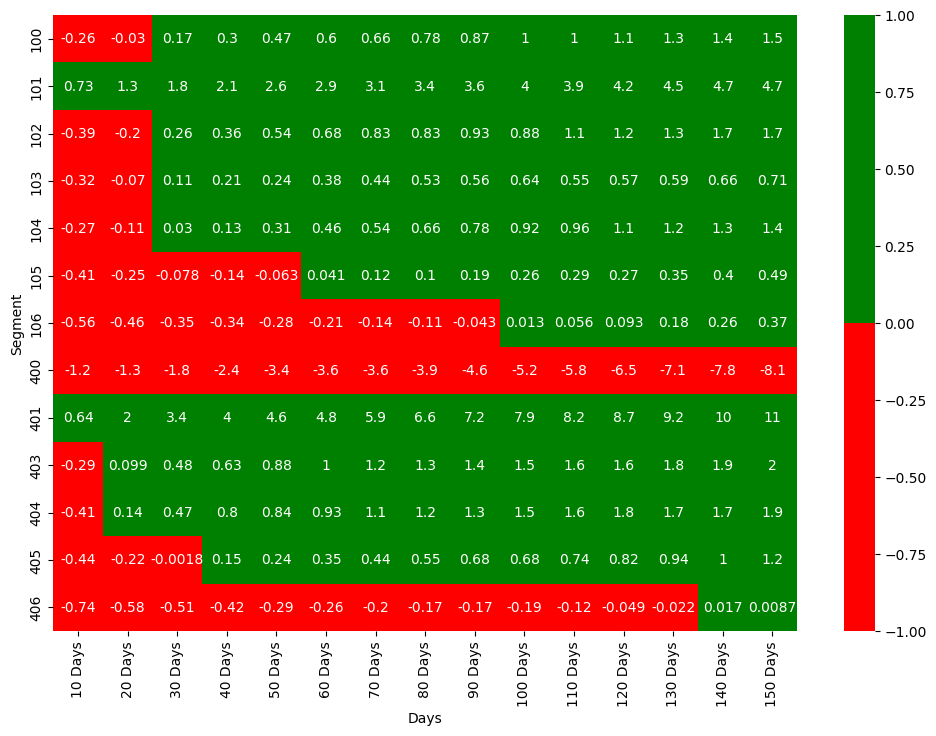

In [12]:
# Set Cost To Current Mailing Costs.
cost = 0.82

# Subtract holdout ppc from segment ppc to find lift across all segments.
result_df = segment_ppc_df.iloc[:, 1:] - holdout_ppc_df.iloc[:, 1:] - cost
result_df.insert(0, 'segment', segment_ppc_df['segment'])

result_df.set_index('segment', inplace=True)

# Define the custom discrete colormap
cmap = mcolors.ListedColormap(['red', 'green'])

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(result_df, annot=True, cmap=cmap, vmin=-1, vmax=1)

# Set the labels
plt.xlabel('Days')
plt.ylabel('Segment')

# Show the plot
plt.show()

### Findings

We're setting a 25c per catalog in incremental revenue.

* 105 begins to meet the ppc target after 100 days.
* 106 begins to actually meet the revenue target 140 days.
* 405 begins to meet the ppc target after 50 days.
* 406 won't meet the ppc target until 200+ days.

# Historical Catalog Sends
* We're going to pull in our active customer segment counts.
    * Our customer segments remain relatively constant because of our customer lifecycle, they're ok to estimate with.
* Then only send catalogs within the time periods for poorer performing segments during our bigger seasonal catalogs.

In [13]:
# Pull in active mailing list.
active_mailing = ("EXEC Netsuite.report.catalog @Brand = '"+brand+"'")

# Run Query.
active_mailing_df = pd.read_sql(active_mailing, engine)

In [14]:
# Group segment counts.
active_segment_counts = active_mailing_df.groupby('segment')['customerid'].count().reset_index()

# Order by 'segment' in ascending order
active_segment_counts = active_segment_counts.sort_values('segment', ascending=True)

print("All active segment counts:")
display(active_segment_counts)

All active segment counts:


,segment,customerid
0,000,774
1,010,96
2,100,7279
3,101,27885
4,103,14042
5,104,9225
6,105,27402
7,106,44707
8,400,601
9,401,3597


## Thoughts
* We should consider JL / NV as our reactivation catalogs.
  * Keep in mind, 106 payback window doesn't outperform the hold out group until 4 months later.
* Suggestions:
  * 100-103: Every mailing.
  * 104: 4-5 Mailings / Yr.
    * 3 month window, cust should recieve at least 1 catalog during this duration.
  * 105: 3 Mailings / Year.
  * 106: 1-2 Mailings / Year.

In [21]:
# A bad, but passable visual reference for when we're mailing groups, and their expected mailing size.

# Total Counts
total_active_count = active_mailing_df['customerid'].count()
total_message = "Total Eligible Customers: " + str(total_active_count)

# Total Counts Minus Abyss
remove_abyss_count = active_mailing_df[~active_mailing_df['segment'].isin(["106", "406"])]['customerid'].count()
remove_abyss_message = "Total Eligible W/o Abyss: " + str(remove_abyss_count)

# Total Counts Minus Abyss + Reactivate
remove_abyss_reactivate_count = active_mailing_df[~active_mailing_df['segment'].isin(["106", "406", "105", "405"])]['customerid'].count()
remove_abyss_reactivate_message = "Total Eligible W/o Abyss / Reactivate: " + str(remove_abyss_reactivate_count)

# Total Counts Minus Abyss + Reactivate + At Risk
remove_abyss_reactivate_atrisk_count = active_mailing_df[~active_mailing_df['segment'].isin(["106", "406", "105", "405", "404", "104"])]['customerid'].count()
remove_abyss_reactivate_atrisk_message = "Total Eligible W/o Abyss / Reactivate / At Risk: " + str(remove_abyss_reactivate_atrisk_count)

# Creating the DataFrame
order = ['WN', 'MC', 'AP', 'MY', 'JL', 'SE', 'OC', 'NV', 'DC']
values = {
  "WN": ["100", "101", "103", "104", "105", "", "", remove_abyss_count],
  "MC": ["100", "101", "103", "", "", "", "", remove_abyss_reactivate_atrisk_count],
  "AP": ["100", "101", "103", "104", "", "", "", remove_abyss_reactivate_count],
  "MY": ["100", "101", "103", "", "", "", "", remove_abyss_reactivate_atrisk_count],
  "JL": ["100", "101", "103", "104", "105", "106", "", total_active_count],
  "SE": ["100", "101", "103", "", "", "", "", remove_abyss_reactivate_atrisk_count],
  "OC": ["100", "101", "103", "104", "", "", "", remove_abyss_reactivate_count],
  "NV": ["100", "101", "103", "104", "105", "106", "", total_active_count],
  "DC": ["", "", "", "", "", "", "", ""]
}

# Converting the dictionary into a DataFrame with NaN for missing values
calendar_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in values.items()]))
display(calendar_df)

,WN,MC,AP,MY,JL,SE,OC,NV,DC
0,100,100,100,100,100,100,100,100,
1,101,101,101,101,101,101,101,101,
2,103,103,103,103,103,103,103,103,
3,104,,104,,104,,104,104,
4,105,,,,105,,,105,
5,,,,,106,,,106,
6,,,,,,,,,
7,95376,55095,65319,55095,144562,55095,65319,144562,
